# UTS SOAL NOMOR 2
Mochamad Aulia Akbar Praditomo
(1606827145)

In [58]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

In [60]:
data = pd.read_csv("../input/dataset_fixed.csv", parse_dates=["timestamp"])

In [112]:
data.head(5)

,co2,temp,humidity,light,hour,weekday,node_0,node_1,node_9
0,0.974895,-0.477397,0.119785,-0.876130,-0.431104,1,1,0,0
1,1.076646,-0.477397,0.119785,-0.880403,-0.431104,1,1,0,0
2,1.133174,-0.477397,0.119785,-0.880403,-0.431104,1,1,0,0
3,1.087951,-0.477397,0.119785,-0.884675,-0.431104,1,1,0,0
4,1.291453,-0.449303,0.127508,-0.884675,-0.431104,1,1,0,0


# Feature Engineering

### Konversi dan pembuangan kolom

In [62]:
data = data.drop("id", axis=1)
data[["co2"]] = pd.to_numeric(data["co2"], errors="coerce")
data[["temp"]] = pd.to_numeric(data["temp"], errors="coerce")
data[["humidity"]] = pd.to_numeric(data["humidity"], errors="coerce")
data[["light"]] = pd.to_numeric(data["light"], errors="coerce")

### Menghapus outliers

In [67]:
def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

data = remove_outlier(data, "co2")
data = remove_outlier(data, "temp")
data = remove_outlier(data, "humidity")
data = remove_outlier(data, "light")
data = remove_outlier(data, "node")

### Feature Extracting

In [73]:
from datetime import datetime

In [74]:
def timestamp_to_hour(row):
    timestamp = row["timestamp"]
    date=datetime.fromtimestamp(int(timestamp))
    return int(date.strftime("%H"))

In [75]:
def timestamp_to_is_weekday(row):
    timestamp = row["timestamp"]
    date=datetime.fromtimestamp(int(timestamp))
    return int(date.weekday() < 5)

#### Tambah feature "hour"

In [76]:
data["hour"] = data.apply(timestamp_to_hour, axis=1)

#### Tambah feature "weekday"

In [77]:
data["weekday"] = data.apply(timestamp_to_is_weekday, axis=1)

#### Isi atau hapus NaN

In [78]:
data.isna().sum()

timestamp    0
co2          0
temp         0
humidity     0
light        0
node         0
hour         0
weekday      0
dtype: int64

## Data visualisation

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f56514935c0>,
      dtype=object)

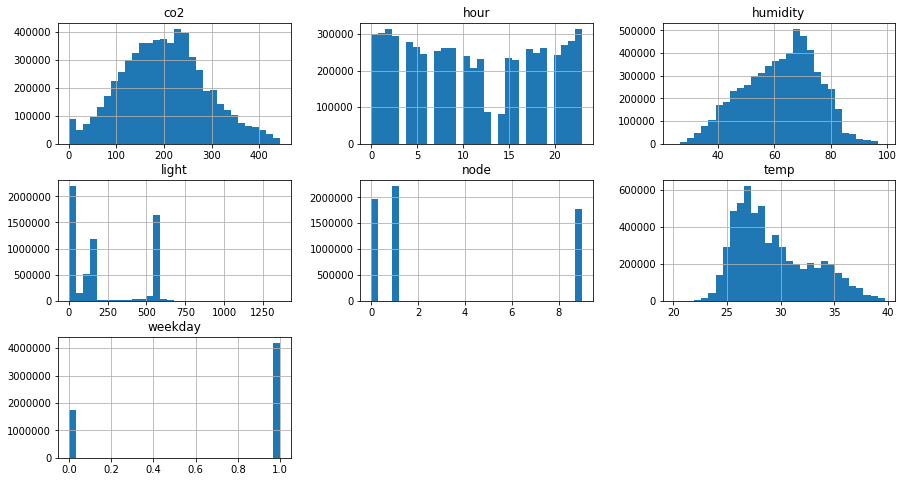

In [79]:
data.hist(bins=30, figsize=(15,8))

Correlation matrix:

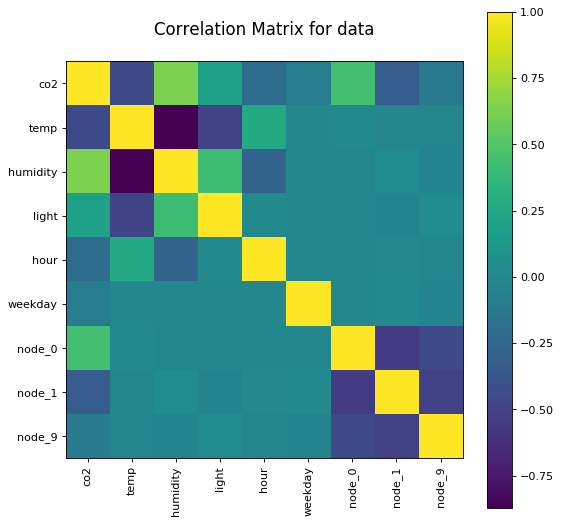

In [104]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for data', fontsize=15)
    plt.show()

plotCorrelationMatrix(data, 8)

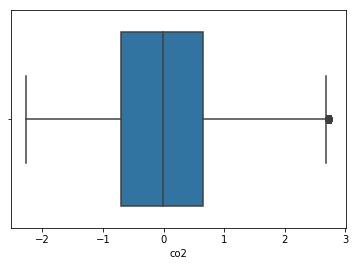

In [108]:
sns.boxplot(x="co2", data=data)

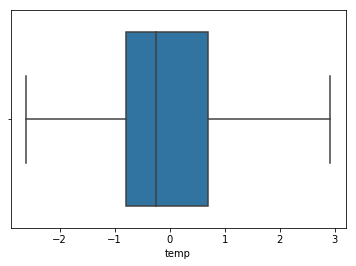

In [109]:
sns.boxplot(x="temp", data=data)

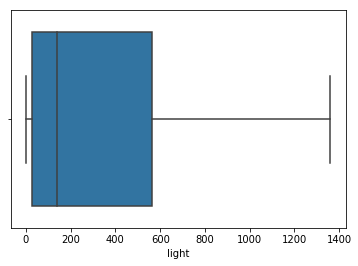

In [83]:
sns.boxplot(x="light", data=data)

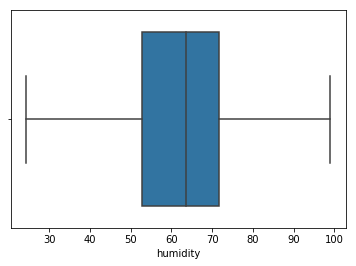

In [84]:
sns.boxplot(x="humidity", data=data)

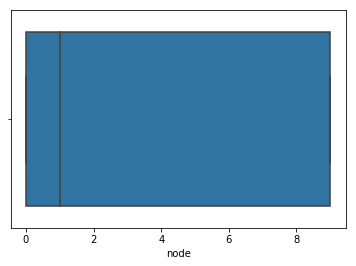

In [85]:
sns.boxplot(x="node", data=data)

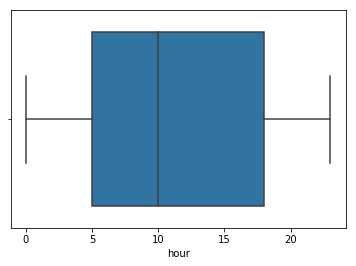

In [86]:
sns.boxplot(x="hour", data=data)

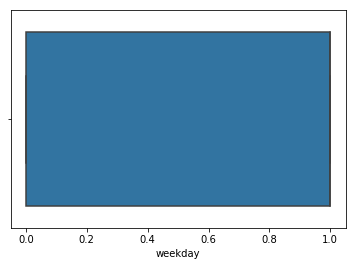

In [87]:
sns.boxplot(x="weekday", data=data)

In [88]:
dummies = pd.get_dummies(data["node"], prefix="node")
data = pd.concat([data.drop("node", axis=1), dummies], axis=1)

# Scaling

In [89]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

#### Drop timestamp

In [90]:
data = data.drop("timestamp", axis=1)

#### Scale data

In [91]:
data.columns.values

array(['co2', 'temp', 'humidity', 'light', 'hour', 'weekday', 'node_0',
       'node_1', 'node_9'], dtype=object)

In [92]:
data_num = data.drop(["weekday", "node_0", "node_1", "node_9"], axis=1)
data_categ = data.loc[:, "weekday":"node_9"]

In [93]:
cols = data_num.columns.values
data_num = pd.DataFrame(data=sc.fit_transform(data_num), columns=cols)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [94]:
data_num[["weekday", "node_0", "node_1", "node_9"]] = data_categ.reset_index().loc[:, "weekday":"node_9"]

In [95]:
data = data_num

In [96]:
data.shape

(5959493, 9)

In [97]:
Y = data.loc[:, "temp"].values
X = data.drop("temp", axis=1).values

## Machine Learning

In [98]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

In [100]:
lr = LinearRegression()
rid = Ridge()
sgd = SGDRegressor(tol=1e-6)
dt = DecisionTreeRegressor(max_depth=7)
rf = RandomForestRegressor(n_estimators=80, max_depth=7)

In [101]:
lr.fit(X_train, y_train)
rid.fit(X_train, y_train)
sgd.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, tol=1e-06, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [103]:
print("RESULTS")
print("Linear Regression:", lr.score(X_test, y_test))
print("Ridge Regression:", rid.score(X_test, y_test))
print("SGD Regression:", sgd.score(X_test, y_test))
print("Decision Tree Regression:", dt.score(X_test, y_test))
print("Random Forest Regression:", rf.score(X_test, y_test))

ACCURACY
Linear Regression: 0.8032019384800372
Ridge Regression: 0.8032019949695551
SGD Regression: 0.8031261710318577
Decision Tree Regression: 0.917158057876875
Random Forest Regression: 0.9185416241505662
